# Model Evaluation

In this notebook, I will test multiple model and evaluate to choose the best one.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, SCORERS
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

pd.set_option('precision', 4)
pd.options.display.max_seq_items = None
pd.options.display.max_columns = 50

In [2]:
X = pd.read_pickle('PKL/X_train.pkl')
y = pd.read_pickle('PKL/Y_train.pkl')

## Train/Test Split
I'm actually going to split my train data once more. It's because this is a competition dataset and I actually don't have the 'test' score result. So I will use the initial test features as a holdout set, and make another subset of train/test for validations.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 13, test_size = 0.2)

In [4]:
# One Hot Encoding 
X_train_ohe = pd.get_dummies(X_train)
X_test_ohe = pd.get_dummies(X_test)

In [5]:
# Check if they have the same features
X_train_ohe.shape[1] == X_test_ohe.shape[1]

False

In [6]:
[x for x in X_train_ohe.columns if x not in X_test_ohe.columns]

['lga_nyamagana']

In [7]:
# one feature got dropped out (during dummy creation by missing an observation, I'll input it as 0 in test set for now.)
X_test_ohe['lga_nyamagana'] = 0

In [8]:
[x for x in X_test_ohe.columns if x not in X_train_ohe.columns]

[]

## Dummy Classifier
I'll create a dummy classifier as a baseline score.

In [9]:
score_keeper = {}

In [10]:
from sklearn.dummy import DummyClassifier
dummyc = DummyClassifier() # using the default stratified strategy
dummyc.fit(X_train_ohe, y_train)
y_pred = dummyc.predict(X_test)

f1_test = round(f1_score(y_test, y_pred, average = 'weighted'), 3)
acc_test = round(accuracy_score(y_test, y_pred), 3)
print('Test F1 score: ', f1_test, '/ Test Accuracy: ', acc_test)
score_keeper['baseline'] = (f1_test, acc_test)

C:\Users\Eunjoo\anaconda3\lib\site-packages\sklearn\dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


Test F1 score:  0.448 / Test Accuracy:  0.449


## Class Imbalance Issue
Our dataset has high class imbalance issue. We will deal with this by setting the class weight within each model.

## KNN
First, I will run K-Nearest Neighbors using GridSearchCV. 

### Standardization
For KNN, I will standardize all feature values.

In [11]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train_ohe)
X_test_scaled = scale.transform(X_test_ohe)

Then I'll try to find the optimal hyperparameters using GridSearchCV.

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
params = {
    'n_neighbors': range(1, 16, 2), # setting K
}

knc = KNeighborsClassifier(weights = 'distance') 
knc_g = GridSearchCV(knc, params, cv = 5, scoring = 'f1_weighted', verbose = 1, n_jobs = -1)
knc_g.fit(X_train_scaled, y_train)
print(knc_g.best_params_, ': ', knc_g.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [12]:
# KNN performance on the test set
y_pred = knc_g.best_estimator_.predict(X_test_scaled)    
f1_test = round(f1_score(y_test, y_pred, average = 'weighted'), 3)
acc_test = round(accuracy_score(y_test, y_pred), 3)

print('Test F1 score: ', f1_test, '/ Test Accuracy: ', acc_test)
score_keeper['knn_gsc'] = (f1_test, acc_test)

Test F1 score:  0.684 / Test Accuracy:  0.692


In [16]:
# saving the model 
mod = open('PKL/knn_gsc.pkl', 'wb')
pickle.dump(knc_g.best_estimator_, mod)
mod.close()

Now I want to try different optimization method to make sure I have the best hyperparmeter for KNN. This time I'll use optuna to explore even more hyperparameters. I'll cap the time to what it took to run the GridSearch above.

In [ ]:
import optuna
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [ ]:
def find_hyperp_KNN(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 31)
    algorithm = trial.suggest_categorical('algorithm', ['ball_tree', 'kd_tree'])
    leaf_size = trial.suggest_int('leaf_size', 2, 60)
    p = trial.suggest_categorical('p', [1, 2])
    knc = KNeighborsClassifier(weights = 'distance', 
                             n_neighbors = n_neighbors, 
                             algorithm = algorithm, 
                             leaf_size = leaf_size, 
                             p = p)
    cv = KFold(n_splits = 5, shuffle = True, random_state = 20)
    score = np.mean(cross_val_score(knc, X_train_scaled, y_train, scoring = 'f1_weighted', cv = cv, n_jobs = -1))
    return (score)

knn_study = optuna.create_study(direction='maximize')
knn_study.optimize(find_hyperp_KNN, timeout = )

In [ ]:
# saving the study 
mod = open('PKL/knn_study.pkl', 'wb')
pickle.dump(knn_study, mod)
mod.close()

In [30]:
# Testing the best params on the test set
knc_opt = KNeighborsClassifier(algorithm = 'kd_tree', leaf_size = 3, n_neighbors=9, weights = 'distance')
knc_opt.fit(X_train_scaled, y_train)

y_pred = knc_opt.predict(X_test_scaled)    
f1_test = round(f1_score(y_test, y_pred, average = 'weighted'), 3)
acc_test = round(accuracy_score(y_test, y_pred), 3)

print('Test F1 score: ', f1_test, '/ Test Accuracy: ', acc_test)
score_keeper['knn_opt'] = (f1_test, acc_test)

Test F1 score:  0.684 / Test Accuracy:  0.692


## Random Forest 
Since Optuna performance was better above, now I'll run random forest using Optuna.

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [37]:
def find_hyperparam_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 2, 8)
    min_samples_split = trial.suggest_int('min_samples_split', 0, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    class_weight = trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample'])
    max_features = trial.suggest_int('max_features', 2, 20)
    rfc = RandomForestClassifier(oob_score = True, 
                             n_estimators = n_estimators, 
                             max_depth = max_depth, 
                             min_samples_split = min_samples_split, 
                             min_samples_leaf = min_samples_leaf, 
                             criterion = criterion, 
                             class_weight = class_weight, 
                             max_features = max_features)
    cv = KFold(n_splits = 5, shuffle = True, random_state = 20)
    score = np.mean(cross_val_score(rfc, X_train_ohe, y_train, scoring = 'f1_weighted', cv = cv, n_jobs = -1))
    return (score)

rfc_study = optuna.create_study(direction='maximize')
rfc_study.optimize(find_hyperparam_rf, timeout = 12780)

[I 2020-08-17 20:29:14,977] Trial 0 finished with value: 0.6263656747260805 and parameters: {'n_estimators': 286, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 7, 'criterion': 'gini', 'class_weight': 'balanced', 'max_features': 9}. Best is trial 0 with value: 0.6263656747260805.
[I 2020-08-17 20:29:31,707] Trial 1 finished with value: 0.6535663913395648 and parameters: {'n_estimators': 156, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 13}. Best is trial 1 with value: 0.6535663913395648.
[I 2020-08-17 20:29:37,639] Trial 2 finished with value: 0.6094881045418552 and parameters: {'n_estimators': 50, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 6, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 4}. Best is trial 1 with value: 0.6535663913395648.
[I 2020-08-17 20:29:57,672] Trial 3 finished with value: 0.6532178643667603 and parameters: {'n_es

[I 2020-08-17 20:42:56,905] Trial 75 finished with value: 0.6875482324106696 and parameters: {'n_estimators': 138, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_features': 13}. Best is trial 57 with value: 0.6922190651753233.
[W 2020-08-17 20:42:58,292] Trial 76 failed, because the objective function returned nan.
[I 2020-08-17 20:43:11,739] Trial 77 finished with value: 0.6731767585950561 and parameters: {'n_estimators': 118, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 5, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'max_features': 10}. Best is trial 57 with value: 0.6922190651753233.
[I 2020-08-17 20:43:30,406] Trial 78 finished with value: 0.683086003090814 and parameters: {'n_estimators': 181, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 4, 'criterion': 'gini', 'class_weight': 'balanced', 'max_features': 15}. Best is trial 57 with value: 0.6922190651753233.
[W 

[I 2020-08-17 20:54:00,305] Trial 159 finished with value: 0.687617213623329 and parameters: {'n_estimators': 107, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 11, 'criterion': 'gini', 'class_weight': 'balanced', 'max_features': 20}. Best is trial 151 with value: 0.6933315178046233.
[I 2020-08-17 20:54:13,938] Trial 160 finished with value: 0.6782448601024327 and parameters: {'n_estimators': 111, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 10, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 18}. Best is trial 151 with value: 0.6933315178046233.
[W 2020-08-17 20:54:15,419] Trial 161 failed, because the objective function returned nan.
[W 2020-08-17 20:54:16,900] Trial 162 failed, because the objective function returned nan.
[W 2020-08-17 20:54:18,321] Trial 163 failed, because the objective function returned nan.
[I 2020-08-17 20:54:29,775] Trial 164 finished with value: 0.6854789048676915 and parameters: {'n_estimators': 90, 'ma

[I 2020-08-17 21:11:55,952] Trial 245 finished with value: 0.6916966407101364 and parameters: {'n_estimators': 253, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 6, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_features': 20}. Best is trial 220 with value: 0.6934089481947603.
[W 2020-08-17 21:11:57,433] Trial 246 failed, because the objective function returned nan.
[I 2020-08-17 21:12:28,164] Trial 247 finished with value: 0.6916988944793789 and parameters: {'n_estimators': 250, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 6, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_features': 20}. Best is trial 220 with value: 0.6934089481947603.
[I 2020-08-17 21:12:58,611] Trial 248 finished with value: 0.6946803258718337 and parameters: {'n_estimators': 253, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 6, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_features': 20}. Best is trial 248 with value: 0.6946803258718337.
[I 

[I 2020-08-17 21:41:24,958] Trial 300 finished with value: 0.663423065177313 and parameters: {'n_estimators': 282, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'max_features': 18}. Best is trial 293 with value: 0.696948896200944.
[I 2020-08-17 21:42:01,753] Trial 301 finished with value: 0.6943128231952719 and parameters: {'n_estimators': 290, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'max_features': 18}. Best is trial 293 with value: 0.696948896200944.
[I 2020-08-17 21:42:38,375] Trial 302 finished with value: 0.6913478055002359 and parameters: {'n_estimators': 289, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'max_features': 17}. Best is trial 293 with value: 0.696948896200944.
[I 2020-08-17 21:43:14,426] Trial 303 finished with value: 0.6934199

[I 2020-08-17 22:11:52,398] Trial 353 finished with value: 0.6930669226610823 and parameters: {'n_estimators': 265, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'max_features': 17}. Best is trial 293 with value: 0.696948896200944.
[I 2020-08-17 22:12:27,110] Trial 354 finished with value: 0.6958209113875101 and parameters: {'n_estimators': 278, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'max_features': 18}. Best is trial 293 with value: 0.696948896200944.
[I 2020-08-17 22:13:01,976] Trial 355 finished with value: 0.694405098437266 and parameters: {'n_estimators': 275, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'max_features': 18}. Best is trial 293 with value: 0.696948896200944.
[I 2020-08-17 22:13:36,597] Trial 356 finished with value: 0.6942408

[I 2020-08-17 22:39:48,592] Trial 410 finished with value: 0.6942361678393328 and parameters: {'n_estimators': 282, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'max_features': 19}. Best is trial 293 with value: 0.696948896200944.
[W 2020-08-17 22:39:50,093] Trial 411 failed, because the objective function returned nan.
[I 2020-08-17 22:40:25,697] Trial 412 finished with value: 0.6951791337067026 and parameters: {'n_estimators': 280, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'max_features': 19}. Best is trial 293 with value: 0.696948896200944.
[W 2020-08-17 22:40:27,142] Trial 413 failed, because the objective function returned nan.
[I 2020-08-17 22:41:03,086] Trial 414 finished with value: 0.6939135625335986 and parameters: {'n_estimators': 280, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'ent

[I 2020-08-17 23:07:06,084] Trial 469 finished with value: 0.6938024815868908 and parameters: {'n_estimators': 279, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 2, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'max_features': 20}. Best is trial 455 with value: 0.6980635968472113.
[I 2020-08-17 23:07:42,934] Trial 470 finished with value: 0.6947531206225129 and parameters: {'n_estimators': 284, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 2, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'max_features': 20}. Best is trial 455 with value: 0.6980635968472113.
[I 2020-08-17 23:08:17,168] Trial 471 finished with value: 0.6951560530599423 and parameters: {'n_estimators': 267, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'max_features': 19}. Best is trial 455 with value: 0.6980635968472113.
[I 2020-08-17 23:08:53,466] Trial 472 finished with value: 0.697

[I 2020-08-17 23:33:34,677] Trial 526 finished with value: 0.6987085463255431 and parameters: {'n_estimators': 218, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'max_features': 20}. Best is trial 526 with value: 0.6987085463255431.
[I 2020-08-17 23:34:04,029] Trial 527 finished with value: 0.6955629729450937 and parameters: {'n_estimators': 227, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'max_features': 20}. Best is trial 526 with value: 0.6987085463255431.
[I 2020-08-17 23:34:32,632] Trial 528 finished with value: 0.6961887382144851 and parameters: {'n_estimators': 214, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'max_features': 20}. Best is trial 526 with value: 0.6987085463255431.
[I 2020-08-17 23:35:01,461] Trial 529 finished with value: 0.695

[I 2020-08-17 23:56:03,832] Trial 599 finished with value: 0.6948789701777661 and parameters: {'n_estimators': 225, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'max_features': 20}. Best is trial 578 with value: 0.6988590595247401.
[I 2020-08-17 23:56:28,355] Trial 600 finished with value: 0.6923282288770646 and parameters: {'n_estimators': 209, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'max_features': 14}. Best is trial 578 with value: 0.6988590595247401.
[W 2020-08-17 23:56:29,780] Trial 601 failed, because the objective function returned nan.
[I 2020-08-17 23:56:58,431] Trial 602 finished with value: 0.6980334019637924 and parameters: {'n_estimators': 218, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'max_features': 20}. Best is trial 578 with 

In [39]:
# save the study
mod = open('PKL/rfc_study.pkl', 'wb')
pickle.dump(rfc_study, mod)
mod.close()

In [41]:
xgb_study.best_params

{'n_estimators': 230,
 'max_depth': 8,
 'min_samples_split': 3,
 'min_samples_leaf': 1,
 'criterion': 'entropy',
 'class_weight': 'balanced_subsample',
 'max_features': 20}

In [ ]:
rf = RandomForestClassifier(oob_score = True, 
                            n_estimators = 230,
                            max_depth = 8,
                            min_samples_split = 3,
                            min_samples_leaf = 1,
                            criterion = 'entropy',
                            class_weight = 'balanced_subsample',
                            max_features = 20)

rf.fit(X_train_ohe, y_train)

y_pred = rf.predict(X_test_ohe)    
f1_test = round(f1_score(y_test, y_pred, average = 'weighted'), 3)
acc_test = round(accuracy_score(y_test, y_pred), 3)

print('Test F1 score: ', f1_test, '/ Test Accuracy: ', acc_test)
score_keeper['rf_opt'] = (f1_test, acc_test)

## XGBoost
I'll run XGBoost with Optuna to find the best hyperparameter.

In [46]:
import xgboost as xgb

In [54]:
def find_hyperparam(trial):
    eta = trial.suggest_float('eta', 0.001, 0.5)
    max_depth = trial.suggest_int('max_depth', 1, 10)
    min_child_weight = trial.suggest_int('min_child_weight', 0, 10)
    subsample = trial.suggest_float('subsample', 0.1, 1.0)
    sampling_method = trial.suggest_categorical('sampling_method', ['uniform', 'gradient_based'])
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
    num_parallel_tree = trial.suggest_int('num_parallel_tree', 1, 10)
    xgbc = xgb.XGBClassifier(objective = 'multi:softmax', 
                             eta = eta, 
                             num_boost_round = 999, 
                             early_stopping_rounds=10, 
                             max_depth = max_depth, 
                             min_child_weight = min_child_weight, 
                             subsample = subsample, 
                             sampling_method = sampling_method, 
                             colsample_bytree = colsample_bytree, 
                            num_parallel_tree = num_parallel_tree)
    cv = KFold(n_splits = 5, shuffle = True, random_state = 20)
    score = np.mean(cross_val_score(xgbc, X_train_ohe, y_train, scoring = 'f1_weighted', cv = cv, n_jobs = -1))
    return (score)

xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(find_hyperparam, timeout = 15000)

[I 2020-08-18 00:16:24,841] Trial 0 finished with value: 0.7088009382983864 and parameters: {'eta': 0.29621547222690675, 'max_depth': 2, 'min_child_weight': 3, 'subsample': 0.12619641349039828, 'sampling_method': 'uniform', 'colsample_bytree': 0.5187121898701065, 'num_parallel_tree': 6}. Best is trial 0 with value: 0.7088009382983864.
[I 2020-08-18 00:19:11,190] Trial 1 finished with value: 0.7586624806118986 and parameters: {'eta': 0.14053267296974542, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.48363656185014225, 'sampling_method': 'uniform', 'colsample_bytree': 0.8002238810944144, 'num_parallel_tree': 1}. Best is trial 1 with value: 0.7586624806118986.
[I 2020-08-18 00:19:37,010] Trial 2 finished with value: 0.6628615145153934 and parameters: {'eta': 0.12471338451893102, 'max_depth': 1, 'min_child_weight': 2, 'subsample': 0.8075018868147802, 'sampling_method': 'gradient_based', 'colsample_bytree': 0.12998484258556592, 'num_parallel_tree': 3}. Best is trial 1 with value: 0.

[I 2020-08-18 03:42:35,398] Trial 23 finished with value: 0.7742056501871708 and parameters: {'eta': 0.4501468434171518, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.31708526654144276, 'sampling_method': 'gradient_based', 'colsample_bytree': 0.6017276470621973, 'num_parallel_tree': 9}. Best is trial 17 with value: 0.7762099848220413.
[I 2020-08-18 03:53:43,135] Trial 24 finished with value: 0.7706572643982318 and parameters: {'eta': 0.4430172893004138, 'max_depth': 10, 'min_child_weight': 7, 'subsample': 0.2768872763292901, 'sampling_method': 'gradient_based', 'colsample_bytree': 0.5566128284915198, 'num_parallel_tree': 5}. Best is trial 17 with value: 0.7762099848220413.
[I 2020-08-18 03:56:46,363] Trial 25 finished with value: 0.7464422993771185 and parameters: {'eta': 0.49117908754536893, 'max_depth': 7, 'min_child_weight': 7, 'subsample': 0.4380583457908302, 'sampling_method': 'gradient_based', 'colsample_bytree': 0.10026135123822397, 'num_parallel_tree': 7}. Best is tria

In [55]:
mod = open('PKL/xgb_study.pkl', 'wb')
pickle.dump(xgb_study, mod)
mod.close()

In [56]:
xgb_study.best_params

{'eta': 0.38510326138314255,
 'max_depth': 10,
 'min_child_weight': 5,
 'subsample': 0.9157038838723865,
 'sampling_method': 'gradient_based',
 'colsample_bytree': 0.24250458182048928,
 'num_parallel_tree': 8}

In [ ]:
xgbc = xgb.XGBClassifier(eta = 0.385, 
                            max_depth = 10,
                            min_child_weight = 5,
                            subsample = 0.916,
                            sampling_method = 'gradient_based',
                            colsample_bytree = 0.2425,
                            num_parallel_tree = 8, n_jobs= -1, verbosity=1)

xgbc.fit(X_train_ohe, y_train)

y_pred = xgbc.predict(X_test_ohe)    
f1_test = round(f1_score(y_test, y_pred, average = 'weighted'), 3)
acc_test = round(accuracy_score(y_test, y_pred), 3)

print('Test F1 score: ', f1_test, '/ Test Accuracy: ', acc_test)

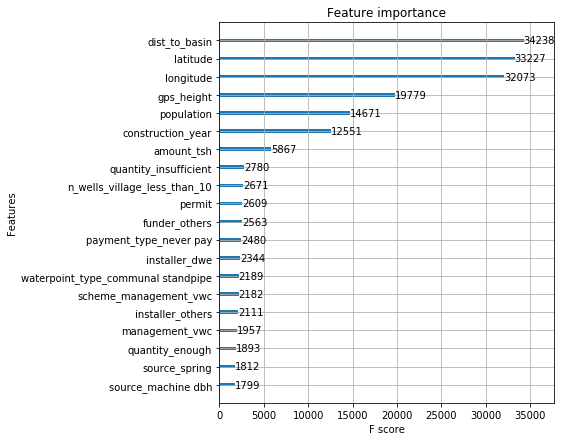

In [77]:
fig, ax = plt.subplots(figsize = (6, 7))
xgb.plot_importance(xgbc, max_num_features = 20, ax = ax)

In [19]:
# random forest gridsearch
params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 5, 0.001], 
    'max_features': [3, 5, 10, 15], 
    'criterion': ['gini', 'entropy'], 
    'class_weight': ['balanced', 'balanced_subsample']
}

rf = RandomForestClassifier(oob_score = True)

rf_g = GridSearchCV(rf, params, cv = 5, scoring = 'f1_weighted', verbose = 1, n_jobs = -1)
rf_g.fit(X_train_ohe, y_train)

print(rf_g.best_params_, ': ', rf_g.best_score_)

y_pred = rf_g.best_estimator_.predict(X_test_ohe)    
f1_test = round(f1_score(y_test, y_pred, average = 'weighted'), 3)
acc_test = round(accuracy_score(y_test, y_pred), 3)

print('Test F1 score: ', f1_test, '/ Test Accuracy: ', acc_test)
score_keeper['rand_forest_gsc_1'] = (f1_test, acc_test)

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 33.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 49.1min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 68.4min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 88.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 112.7min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 140.5min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 172.3min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 207.4min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 245.4min
[Parallel(n_jobs=-1)]: Done 8640 out of 8640 | elapsed: 253.1min finished


{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 7, 'max_features': 15, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 150} :  0.6852358948077846
Test F1 score:  0.686 / Test Accuracy:  0.663


In [ ]:
# XGBoost_ gridsearch
params = {
    'eta': [0.001, 0.01, 0.1], 
    'max_depth': [3, 5, 7], 
    'min_child_weight': [0, 1, 10], 
    'subsample': [.5, .75, 1], 
}

xgbc = xgb.XGBClassifier(objective = 'multi:softmax')
xgbc_g = GridSearchCV(xgbc, params, cv = 5, scoring = 'f1_weighted', verbose = 1, n_jobs = -1)
xgbc_g.fit(X_train_ohe, y_train)

print(xgbc_g.best_params_, ': ', xgbc_g.best_score_)

y_pred = xgbc_g.best_estimator_.predict(X_test_ohe)    
f1_test = round(f1_score(y_test, y_pred, average = 'weighted'), 3)
acc_test = round(accuracy_score(y_test, y_pred), 3)

print('Test F1 score: ', f1_test, '/ Test Accuracy: ', acc_test)
score_keeper2['xgb_gsc_v1'] = (f1_test, acc_test)

mod = open('PKL/xgb_gsc_v1.pkl', 'wb')
pickle.dump(xgbc_g.best_estimator_, mod)
mod.close()